Define number of states (also called $n$ later).

In [1]:
num_uni_dist_states = 12
num_permuted_states = 4

# qiskit state plots
from qiskit.circuit import ClassicalRegister
from qiskit import Aer, transpile
from qiskit.visualization import plot_histogram

# 1. Uniform Distribution
An uniform distribution over an arbitrary number of states $n$ with $n_\pi=2^{\lceil \log_2 n\rceil}$, archieved by a single grover step with a tuned selection and diffusion angle as proposed by Ryan Babbush et al. in [Encoding Electronic Spectra in Quantum Circuits with Linear T Complexity (2018)](https://arxiv.org/pdf/arXiv:1805.03662.pdf), figure 12. Uses the qiskit [IntegerComparator](https://qiskit.org/documentation/stubs/qiskit.circuit.library.IntegerComparator.html) which is based of a subtraction where only the carry-out bit is affected while the other solution / ancilla qubits are uncomputed. The circuit performs $UniDist(n)|0\rangle^{n_\pi} \otimes |0\rangle^{n_\pi-j} = \frac{1}{\sqrt{n}}\sum_{k<n}|k\rangle \otimes |0\rangle^{n_\pi-j}$, where $j$ is the lowest index in $n = (n_{n_\pi} n_{n_\pi-1}\dots n_j 0 \dots 0)$ with $n_j=1$. The integer comparators and MCNOT gates act on $j$ qubits with V-chains, the other components are Hadamard (used $n_\pi+2j$ times), NOT gates (used $2j$ times) and the $2$ RZ gates. Therefore the size is $size(UniDist(n))= \mathcal{O}(\log_2 n)$ and $depth(UniDist(n))=  \mathcal{O}(\log_2 n)$.

In [2]:
from library.distributions import UniformDistribution

UniformDistribution(num_uni_dist_states).decompose().draw(fold=-1)

┌───┐                                                                          
simple_0: ┤ H ├──────────────────────────────────────────────────────────────────────────
          ├───┤                                                                          
simple_1: ┤ H ├──────────────────────────────────────────────────────────────────────────
          ├───┤┌───────┐             ┌───────┐┌───┐┌───┐                       ┌───┐┌───┐
grover_0: ┤ H ├┤0      ├─────────────┤0      ├┤ H ├┤ X ├──■─────────────────■──┤ X ├┤ H ├
          ├───┤│       │             │       │├───┤├───┤  │                 │  ├───┤├───┤
grover_1: ┤ H ├┤1      ├─────────────┤1      ├┤ H ├┤ X ├──■─────────────────■──┤ X ├┤ H ├
          └───┘│  qg<3 │┌───────────┐│  qg<3 │└───┘└───┘┌─┴─┐┌───────────┐┌─┴─┐└───┘└───┘
   phase: ─────┤2      ├┤ Rz(1.231) ├┤2      ├──────────┤ X ├┤ Rz(1.231) ├┤ X ├──────────
               │       │└───────────┘│       │          └───┘└───────────┘└───┘          
     aux: ─────┤3      ├─────────────┤3      ├───────────────────────────────────────────
               └───────┘             └───────┘

Distribution visualization.

Number of states: 12


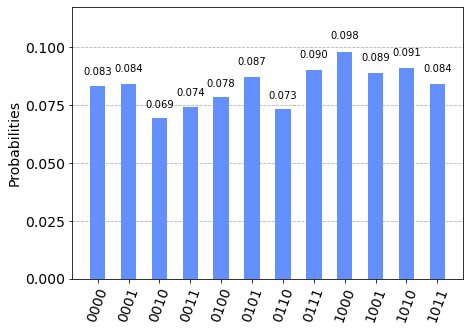

In [3]:
uni_dist = UniformDistribution(num_uni_dist_states)

cr = ClassicalRegister(uni_dist.num_state_qubits)
uni_dist.add_register(cr)
for i in range(len(cr)):
    uni_dist.measure(i, cr[i])

backend_sim = Aer.get_backend('qasm_simulator')
result_sim = backend_sim.run(transpile(uni_dist, backend_sim), shots=1024).result()
print("Number of states:", len(result_sim.get_counts()))
fig = plot_histogram(result_sim.get_counts(uni_dist))
fig.set_facecolor("white")
fig

# Superposition of Permutations

Using the Lehmer code circuits presented in the permutation circuit chapter, the superposition of all possible permutations $\pi$ over $n$ states can be created by first building a superposition over all possible digits for the Lehmer code with $0 \leq d_i < n-i$, i.e. $|\Psi_i\rangle = \frac{1}{\sqrt{n-i}} \sum_{k<n-i} |k\rangle$. Then the Lehmer code is converted into permutations with $LCtoP(n)$ and later uncomputed with $PtoLC(n)^\dagger$. The uniform distributions can use the unitialized permutation registers and are grouped with regards to the maximally necessary ancillas with a greedy bin packing algortihm to reduce the depth.
With  $id(\pi) = \sum_{i<n} d_i \cdot (n-i-1)!$, each permutation can be given a unique index, which can be associated to a permutation state $\Pi(id(\pi)) = \sum_{i<n} \pi_i \cdot 2^{n_\pi \cdot i}$.
Due to $PtoLC(n)$ circuit uses $n_{aux} = \sum_{i<n} \lceil \log_2 (n-i) \rceil+ n_\pi+1$ ancillas, performing $SPPerm(n) |0\rangle^{n\cdot n_\pi} \otimes |0\rangle^{n_{aux}} = \left(\frac{1}{\sqrt{n!}}\sum_{id<n!}|\Pi(id)\rangle \right)  \otimes |0\rangle^{n_{aux}}$. The depth and size are dominated by $LCtoP(n)$ resulting in $size(SPPerm(n)) = \mathcal{O}(n^3 \log_2(n))$ and $depth(SPPerm(n))= \mathcal{O}(n^3 \log_2(n))$.

In [4]:
from library.distributions import SuperPosPerms

SuperPosPerms(num_permuted_states).decompose().draw(fold=-1)

┌─────────┐┌────────────┐
perm_0_0: ────────────────────────┤0        ├┤0           ├
                                  │         ││            │
perm_0_1: ────────────────────────┤1        ├┤1           ├
                                  │         ││            │
perm_1_0: ────────────────────────┤2        ├┤2           ├
                                  │         ││            │
perm_1_1: ────────────────────────┤3        ├┤3           ├
                                  │         ││            │
perm_2_0: ────────────────────────┤4        ├┤4           ├
                                  │         ││            │
perm_2_1: ────────────────────────┤5        ├┤5           ├
                      ┌──────────┐│         ││            │
perm_3_0: ────────────┤3         ├┤6        ├┤6           ├
                      │          ││         ││            │
perm_3_1: ────────────┤2         ├┤7  LCtoP ├┤7           ├
          ┌──────────┐│          ││         ││   PtoLC_dg │
   aux_0: ┤0         ├┤          ├┤8        ├┤8           ├
          │  UniDist ││  UniDist ││         ││            │
   aux_1: ┤1         ├┤          ├┤9        ├┤9           ├
          └──────────┘│          ││         ││            │
   aux_2: ────────────┤0         ├┤10       ├┤10          ├
                      │          ││         ││            │
   aux_3: ────────────┤1         ├┤11       ├┤11          ├
                      ├─────────┬┘│         ││            │
   aux_4: ────────────┤ UniDist ├─┤12       ├┤12          ├
                      └─────────┘ │         ││            │
   aux_5: ────────────────────────┤13       ├┤13          ├
                                  │         ││            │
   aux_6: ────────────────────────┤14       ├┤14          ├
                                  └─────────┘│            │
   aux_7: ───────────────────────────────────┤15          ├
                                             └────────────┘

Distribution visualization.

Number of states: 24
Permutations with counts:
(0, 1, 2, 3): 42, (0, 1, 3, 2): 49, (0, 2, 1, 3): 39, (0, 2, 3, 1): 44, (0, 3, 1, 2): 45, (0, 3, 2, 1): 28, (1, 0, 2, 3): 45, (1, 0, 3, 2): 45, (1, 2, 0, 3): 47, (1, 2, 3, 0): 43, (1, 3, 0, 2): 36, (1, 3, 2, 0): 44, (2, 0, 1, 3): 52, (2, 0, 3, 1): 49, (2, 1, 0, 3): 42, (2, 1, 3, 0): 49, (2, 3, 0, 1): 39, (2, 3, 1, 0): 34, (3, 0, 1, 2): 38, (3, 0, 2, 1): 39, (3, 1, 0, 2): 38, (3, 1, 2, 0): 51, (3, 2, 0, 1): 43, (3, 2, 1, 0): 43, 


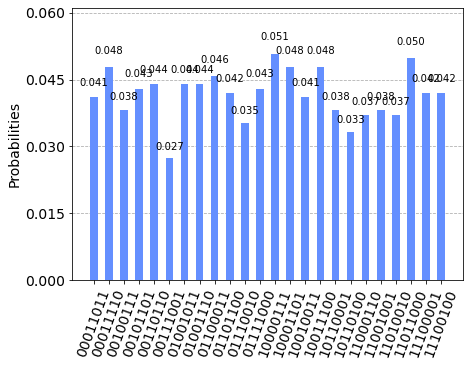

In [5]:
super_pos_perms = SuperPosPerms(num_permuted_states)
num_state_qubits = super_pos_perms.num_state_qubits

cr = ClassicalRegister(super_pos_perms.num_permutation_qubits)
super_pos_perms.add_register(cr)
for i in range(len(cr)):
    super_pos_perms.measure(i, cr[i])

backend_sim = Aer.get_backend('qasm_simulator')
result_sim = backend_sim.run(transpile(super_pos_perms, backend_sim), shots=1024).result()
print("Number of states:", len(result_sim.get_counts()))
print("Permutations with counts:")
for perm_str, counts in sorted(result_sim.get_counts().items(), key=lambda x:x[0]):
    decimal_perm = []
    for _ in range(num_permuted_states):
        decimal_perm.append(int(perm_str[:num_state_qubits], 2))
        perm_str = perm_str[num_state_qubits:]
    print(f"{tuple(decimal_perm)}: {counts}, ", end="")
print()

fig = plot_histogram(result_sim.get_counts(super_pos_perms))
fig.set_facecolor("white")
fig